## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [14]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Setting toolkit folder as working directory

%cd /content/drive/My Drive/1_LiveProjects/Project8_SentimentAnalysis_with_NeuralNetwork
! ls

[Errno 2] No such file or directory: '/content/drive/My Drive/1_LiveProjects/Project8_SentimentAnalysis_with_NeuralNetwork'
/content
a1_IMDB_Dataset.csv  drive  sample_data


In [16]:
# Importing essential libraries and functions
!pip install tensorflow
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Changed import to tensorflow.keras
from tensorflow.keras.models import Sequential # Changed import to tensorflow.keras
from tensorflow.keras.layers import Activation, Dropout, Dense # Changed import to tensorflow.keras and removed .core
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM # Changed import to tensorflow.keras
from sklearn.model_selection import train_test_split

## Loading dataset

In [17]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [18]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [19]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [20]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

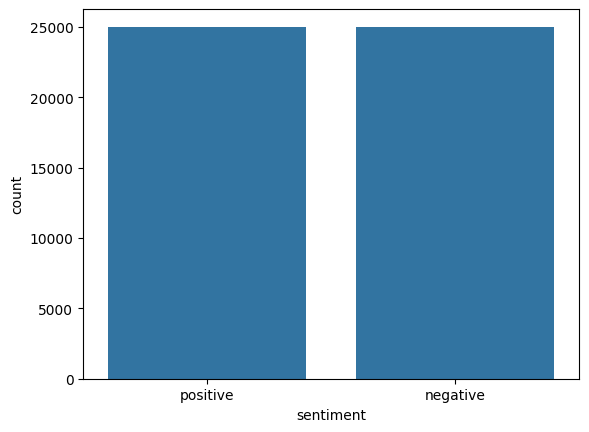

In [21]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [24]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [27]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

  return TAG_RE.sub('', text)

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
def preprocess_text(sen):
  '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase'''

  sentence = sen.lower()

  #remove HTML tags
  sentence = remove_tags(sentence)

  #remove puntuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Remove mutiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  # Remove Stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  sentence = pattern.sub('', sentence)

  return sentence


In [30]:
X =[]
sentences = list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [31]:
X[2] # cleaned movie review

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [32]:
# converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [34]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [35]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [36]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding = 'post', maxlen=maxlen)

In [40]:
from numpy import asarray
from numpy import zeros_like

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [47]:
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and len(embedding_vector) == 100:  # Ensure 100-dimension
        embedding_matrix[index] = embedding_vector


In [48]:
embedding_matrix.shape


(92394, 100)

# Model Training with:

## Simple Neural Network

## Convolutional Neural Network

## Recurrent Neural Network (LSTM)

# Making Predictions on Live IMDb data

In [23]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()